# Redes Neuronales Recurrentes y Prophet para Predicci√≥n de Series Temporales (Core)

Hecho en Colab

**Descripci√≥n:**

En este ejercicio, implementar√°s una red neuronal recurrente (RNN) utilizando LSTM para predecir valores futuros en una serie temporal. Adem√°s, se te pide que explores el uso de la herramienta Prophet, un modelo de predicci√≥n de series temporales desarrollado por Facebook, y compares los resultados obtenidos con los de la RNN.

**Objetivo:**

El objetivo es predecir los valores futuros de una serie temporal utilizando redes recurrentes y comparar su rendimiento con Prophet. Este ejercicio te permitir√° explorar dos enfoques distintos para la predicci√≥n de series temporales.

##Importaciones del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Para hacer gr√°ficos m√°s bonitos
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler  # Para escalar los datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


##Funciones a utilizar

In [2]:
# Funci√≥n para encontrar valores at√≠picos POR el m√©todo de los cuartiles y el rango intercuart√≠lico (IQR). chatgpt
def identificar_atipicos_IQR(df, columnas):
    atipicos = pd.DataFrame()  # DataFrame para almacenar filas con valores at√≠picos

    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Definir l√≠mites para valores at√≠picos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar filas que tienen valores at√≠picos
        filas_atipicas = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

        # Concatenar filas at√≠picas al DataFrame de at√≠picos
        atipicos = pd.concat([atipicos, filas_atipicas])

    return atipicos.drop_duplicates()  # Eliminar duplicados
def ver_resumen_nulos(df):
    qna=df.isnull().sum(axis=0)
    qsna=df.shape[0]-qna

    ppna=round(100*(qna/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    resumen_nulos =na.sort_values(by='Na en %',ascending=False)
    return resumen_nulos
def desc(df, columns=None):
    """
    Genera un cuadro de estad√≠sticas descriptivas con el porcentaje de std/mean incluido.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el c√°lculo. Si es None, se incluyen todas las columnas num√©ricas.

    Returns:
    pd.DataFrame: DataFrame con estad√≠sticas descriptivas y el porcentaje std/mean.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas num√©ricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    return df_describe

def desc_ceros(df, columns=None):
    """
    Genera un cuadro de estad√≠sticas descriptivas filtrando columnas con m√≠nimo o m√°ximo igual a cero,
    e incluye el porcentaje de std/mean.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el c√°lculo. Si es None, se incluyen todas las columnas num√©ricas.

    Returns:
    pd.DataFrame: DataFrame con estad√≠sticas descriptivas y el porcentaje std/mean para las columnas filtradas.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas num√©ricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    # Filtrar las columnas donde el m√≠nimo o el m√°ximo sea igual a cero
    df_describe = df_describe[(df_describe['min'] == 0) | (df_describe['max'] == 0)]

    return df_describe
def imprimir_bigotes(serie):
    """
    Calcula e imprime los bigotes de una serie de datos.

    Parameters:
    serie (pd.Series): La serie de datos para la cual se calcular√°n los bigotes.

    Returns:
    None: Imprime los valores de los bigotes.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los bigotes
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"L√≠mite inferior (bigote inferior): {limite_inferior}")
    print(f"L√≠mite superior (bigote superior): {limite_superior}")
    # Retornar los valores para poder usarlos en otras funciones
    return limite_inferior, limite_superior
def imprimir_bigotes_por_grupo(df, columna, target):
    """
    Imprime los bigotes de los datos por grupo de una columna espec√≠fica.

    Parameters:
    df (pd.DataFrame): El DataFrame con los datos.
    columna (str): La columna sobre la que se calcular√°n los bigotes.
    target (str): La columna que contiene las etiquetas de grupo (por ejemplo, 'Species').

    Returns:
    None: Imprime los bigotes por cada grupo.
    """
    print(f"\nBigotes de {columna} por grupo:")
    for species in df[target].unique():
        print(f"\nEspecie: {species}")
        species_data = df[df[target] == species][columna]
        # Imprimir los bigotes solo una vez
        limite_inferior, limite_superior = imprimir_bigotes(species_data)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def plot_varianza(prm_pca,varianza_minima=90):
    plt.figure(figsize=(12, 6))

    # 1. Ganancia de varianza explicada por cada componente
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(prm_pca.explained_variance_ratio_) + 1),
            prm_pca.explained_variance_ratio_, color='skyblue')
    plt.title('Ganancia de varianza explicada por cada componente')
    plt.xlabel('N√∫mero de Componentes Principales')
    plt.ylabel('Ganancia de Varianza Explicada (%)')
    plt.grid(True)

    # Etiquetas en las barras
    for i, v in enumerate(prm_pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f'{v*100:.2f}%', ha='center')

    # 2. Varianza acumulada
    explained_variance_cumulative = prm_pca.explained_variance_ratio_.cumsum()
    explained_variance_gain = np.diff(explained_variance_cumulative, prepend=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance_cumulative) + 1),
             explained_variance_cumulative, marker='o', linestyle='--', color='orange')
    plt.title('Variaci√≥n Explicada Acumulada')
    plt.xlabel('N√∫mero de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.axhline(y=varianza_minima, color='r', linestyle='--', label=f'{varianza_minima*100}% Umbral')
    plt.axvline(x=np.argmax(explained_variance_cumulative >= varianza_minima) + 1,
                color='g', linestyle='--', label='N√∫mero √≥ptimo de componentes')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Mostrar informaci√≥n en consola
    print("Variaci√≥n explicada acumulada y ganancia:")
    for i, variance in enumerate(explained_variance_cumulative, 1):
        variance_rounded = round(variance, 4)
        print(f"variance_rounded: {variance_rounded}")
        if variance_rounded < 1:
            print(f"Componente {i}: {variance:.2%} ({explained_variance_gain[i-1]*100:.2f}%)")
        else:
          print(f"Existen mas componentes pero ya no aportan variabilidad significativa o es muy infima.")
          break

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)




# Instrucciones:

## 1. Selecci√≥n del dataset:
  - Utiliza un dataset de series temporales de Kaggle, como el de ¬´Air Quality Prediction¬ª o cualquier otro relacionado con predicci√≥n de demanda, precios de acciones, etc. Puedes elegir el dataset que m√°s se relacione con tus intereses.
  - Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)

In [3]:
# Especifica la ruta del archivo
file_path = "/content/train.csv"  # Ajusta el nombre si es diferente
test_path = "/content/test.csv"  # Ajusta el nombre si es diferente
# Cargar el archivo en un DataFrame
#df = pd.read_csv(file_path)
df_test = pd.read_csv(test_path)

df_train = pd.read_csv(file_path)
df = df_train.copy()
# Mostrar las primeras filas
print(df.head())


   No  DEWP  TEMP    PRES cbwd   Iws  Is  Ir  AQI
0   1   -16  -4.0  1020.0   SE  1.79   0   0  129
1   2   -15  -4.0  1020.0   SE  2.68   0   0  148
2   3   -11  -5.0  1021.0   SE  3.57   0   0  159
3   4    -7  -5.0  1022.0   SE  5.36   1   0  181
4   5    -7  -5.0  1022.0   SE  6.25   2   0  138


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB


In [5]:
# Datos del diccionario con la estructura solicitada
data = {
    "columna": ["No", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir", "AQI"],
    "tipo": ["int64", "int64", "float64", "float64", "object", "float64", "int64", "int64", "int64"],
    "Descripcion": [
        "Un n√∫mero secuencial ",
        "Punto de roc√≠o (DEW Point)",
        "Temperatura registrada",
        "Presi√≥n atmosf√©rica",
        "Direcci√≥n combinada del viento",
        "Velocidad acumulada del viento",
        "Horas acumuladas de nieve",
        "Horas acumuladas de lluvia",
        "√çndice de calidad del aire"
    ],
    "Ejemplo": [0, -10, 25.3, 1015.2, "NE", 2.5, 0, 1, 85]
}

# Crear el DataFrame
df_diccionario = pd.DataFrame(data)

# Mostrar el DataFrame
df_diccionario


columna     tipo                     Descripcion Ejemplo
0      No    int64           Un n√∫mero secuencial        0
1    DEWP    int64      Punto de roc√≠o (DEW Point)     -10
2    TEMP  float64          Temperatura registrada    25.3
3    PRES  float64             Presi√≥n atmosf√©rica  1015.2
4    cbwd   object  Direcci√≥n combinada del viento      NE
5     Iws  float64  Velocidad acumulada del viento     2.5
6      Is    int64       Horas acumuladas de nieve       0
7      Ir    int64      Horas acumuladas de lluvia       1
8     AQI    int64      √çndice de calidad del aire      85

##2. Preprocesamiento de datos:
  - Realiza una exploraci√≥n inicial de la serie temporal, incluyendo la visualizaci√≥n de la tendencia y la estacionalidad si es aplicable.
  - Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos est√©n en un rango similar.

In [6]:
ver_resumen_nulos(df)

datos sin NAs en q  Na en q  Na en %
No                 41757        0      0.0
DEWP               41757        0      0.0
TEMP               41757        0      0.0
PRES               41757        0      0.0
cbwd               41757        0      0.0
Iws                41757        0      0.0
Is                 41757        0      0.0
Ir                 41757        0      0.0
AQI                41757        0      0.0

In [7]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el n√∫mero de duplicados
num_duplicados = duplicados.sum()
print(f"N√∫mero de registros duplicados: {num_duplicados}")

N√∫mero de registros duplicados: 0


In [8]:
# 1. Creamos fechas artificiales
# Como no hay fechas, asumimos que cada fila es una medici√≥n por hora
# Empezamos desde el 2020.
df['Fecha'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')

<ipython-input-8-8b0e48063a00>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Fecha'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')


In [9]:
# Primeros registros. Se ve que empieza en el 2020.
df.head()

No  DEWP  TEMP    PRES cbwd   Iws  Is  Ir  AQI               Fecha
0   1   -16  -4.0  1020.0   SE  1.79   0   0  129 2020-01-01 00:00:00
1   2   -15  -4.0  1020.0   SE  2.68   0   0  148 2020-01-01 01:00:00
2   3   -11  -5.0  1021.0   SE  3.57   0   0  159 2020-01-01 02:00:00
3   4    -7  -5.0  1022.0   SE  5.36   1   0  181 2020-01-01 03:00:00
4   5    -7  -5.0  1022.0   SE  6.25   2   0  138 2020-01-01 04:00:00

In [10]:
# Ultimos registros. Se ve que termina en Octubre 2024. Correcto.
df.tail()

No  DEWP  TEMP    PRES cbwd     Iws  Is  Ir  AQI               Fecha
41752  41753   -23  -2.0  1034.0   NW  231.97   0   0    8 2024-10-05 16:00:00
41753  41754   -22  -3.0  1034.0   NW  237.78   0   0   10 2024-10-05 17:00:00
41754  41755   -22  -3.0  1034.0   NW  242.70   0   0   10 2024-10-05 18:00:00
41755  41756   -22  -4.0  1034.0   NW  246.72   0   0    8 2024-10-05 19:00:00
41756  41757   -21  -3.0  1034.0   NW  249.85   0   0   12 2024-10-05 20:00:00

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   No      41757 non-null  int64         
 1   DEWP    41757 non-null  int64         
 2   TEMP    41757 non-null  float64       
 3   PRES    41757 non-null  float64       
 4   cbwd    41757 non-null  object        
 5   Iws     41757 non-null  float64       
 6   Is      41757 non-null  int64         
 7   Ir      41757 non-null  int64         
 8   AQI     41757 non-null  int64         
 9   Fecha   41757 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 3.2+ MB


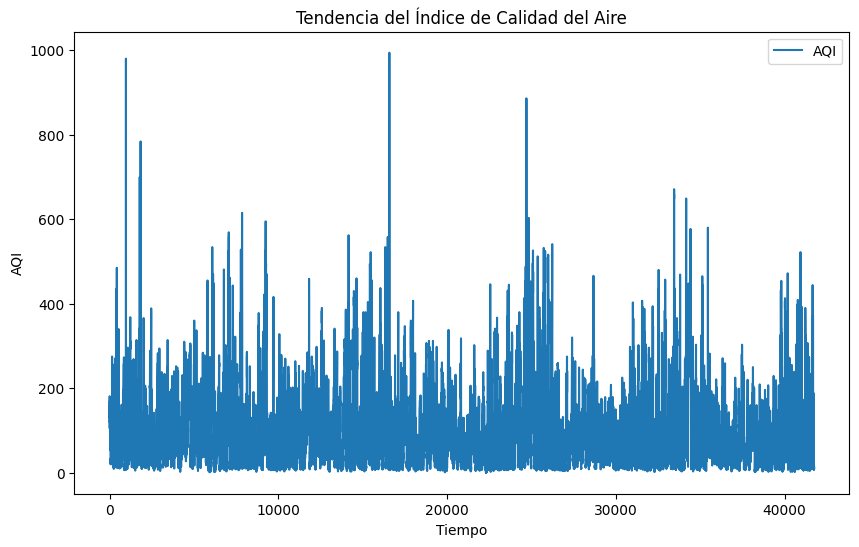

In [12]:
# 2. Visualizar la tendencia del AQI (√çndice de Calidad del Aire)
plt.figure(figsize=(10, 6))  # Hacemos un gr√°fico de tama√±o grande
plt.plot(df['AQI'], label='AQI')  # Dibujamos la l√≠nea del AQI
plt.title('Tendencia del √çndice de Calidad del Aire')  # T√≠tulo del gr√°fico
plt.xlabel('Tiempo')  # Etiqueta en el eje X
plt.ylabel('AQI')  # Etiqueta en el eje Y
plt.legend()  # Mostramos la leyenda
plt.show()  # Mostramos el gr√°fico

In [13]:
# 3 Ponemos la columna 'Fecha' como √≠ndice de la tabla
df = df.set_index('Fecha')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 3.2+ MB


In [15]:
df.head()

No  DEWP  TEMP    PRES cbwd   Iws  Is  Ir  AQI
Fecha                                                              
2020-01-01 00:00:00   1   -16  -4.0  1020.0   SE  1.79   0   0  129
2020-01-01 01:00:00   2   -15  -4.0  1020.0   SE  2.68   0   0  148
2020-01-01 02:00:00   3   -11  -5.0  1021.0   SE  3.57   0   0  159
2020-01-01 03:00:00   4    -7  -5.0  1022.0   SE  5.36   1   0  181
2020-01-01 04:00:00   5    -7  -5.0  1022.0   SE  6.25   2   0  138

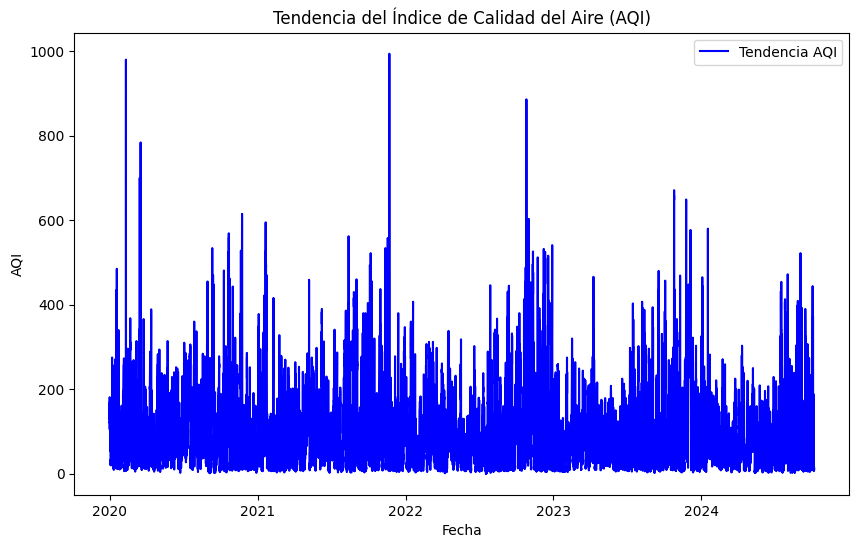

In [16]:
# 3.1 Visualizar la tendencia del AQI (Calidad del Aire) üìà
plt.figure(figsize=(10, 6))  # Hacemos un gr√°fico grande
plt.plot(df['AQI'], label='Tendencia AQI', color='blue')  # Dibujamos el AQI
plt.title('Tendencia del √çndice de Calidad del Aire (AQI)')  # T√≠tulo del gr√°fico
plt.xlabel('Fecha')  # Etiqueta del eje X
plt.ylabel('AQI')  # Etiqueta del eje Y
plt.legend()  # Mostramos la leyenda
plt.show()

In [17]:
# 4. Explorar la estacionalidad üìä
# Calculamos el promedio del AQI para cada mes usando las fechas artificiales
df['Mes'] = df.index.month  # Extraemos el mes de cada fecha
aqi_por_mes = df.groupby('Mes')['AQI'].mean()  # Promediamos AQI por mes

<ipython-input-18-da3c61a5b30f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aqi_por_mes.index, y=aqi_por_mes.values, palette='coolwarm')


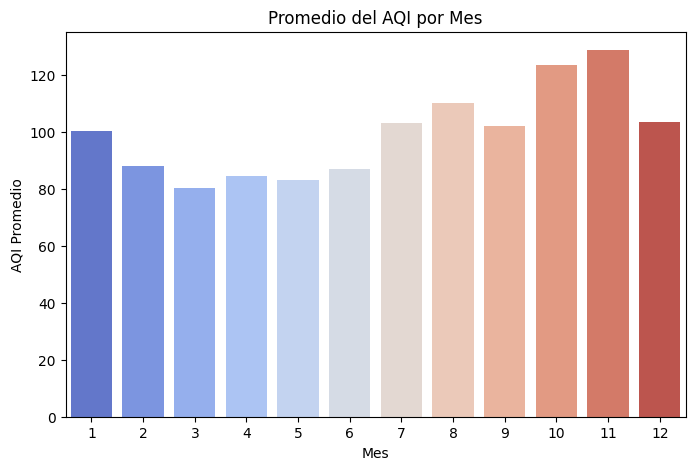

In [18]:
# Hacemos un gr√°fico para ver si hay patrones que se repiten
plt.figure(figsize=(8, 5))
sns.barplot(x=aqi_por_mes.index, y=aqi_por_mes.values, palette='coolwarm')
plt.title('Promedio del AQI por Mes')  # T√≠tulo del gr√°fico
plt.xlabel('Mes')  # Etiqueta en el eje X
plt.ylabel('AQI Promedio')  # Etiqueta en el eje Y
plt.show()

### ¬øQu√© es la estacionalidad? üçÇ‚òÄÔ∏è‚ùÑÔ∏è  

La **estacionalidad** ocurre cuando los datos muestran **patrones que se repiten** en un periodo de tiempo.  
Por ejemplo:  
- En **verano** hace m√°s calor y en **invierno** hace m√°s fr√≠o. üåû‚ùÑÔ∏è  
- Las ventas de √∫tiles escolares suben siempre en **agosto**. üìö  

---

### ¬øC√≥mo saber si hay estacionalidad? üïµÔ∏è‚Äç‚ôÄÔ∏è  
Para ver si hay **patrones repetidos** en los datos:  

1. **Mira los gr√°ficos** üìà:  
   - Si los datos suben y bajan de manera similar cada **mes**, **semana** o **d√≠a**, ¬°eso es estacionalidad!  
   - Por ejemplo, si la Calidad del Aire (AQI) siempre empeora en invierno y mejora en verano, hay **estacionalidad mensual**.  

2. **Promedia los datos por periodo** üóìÔ∏è:  
   - Si haces un gr√°fico del AQI promediado por mes o semana y ves un **patr√≥n**, entonces s√≠ hay estacionalidad.

---

### ¬øQu√© pasa si no hay estacionalidad? ü§î  
Si **no ves patrones repetidos** en los gr√°ficos, eso significa que los datos no tienen estacionalidad.  
En ese caso, solo analizamos si la **tendencia** general sube, baja o se queda igual.


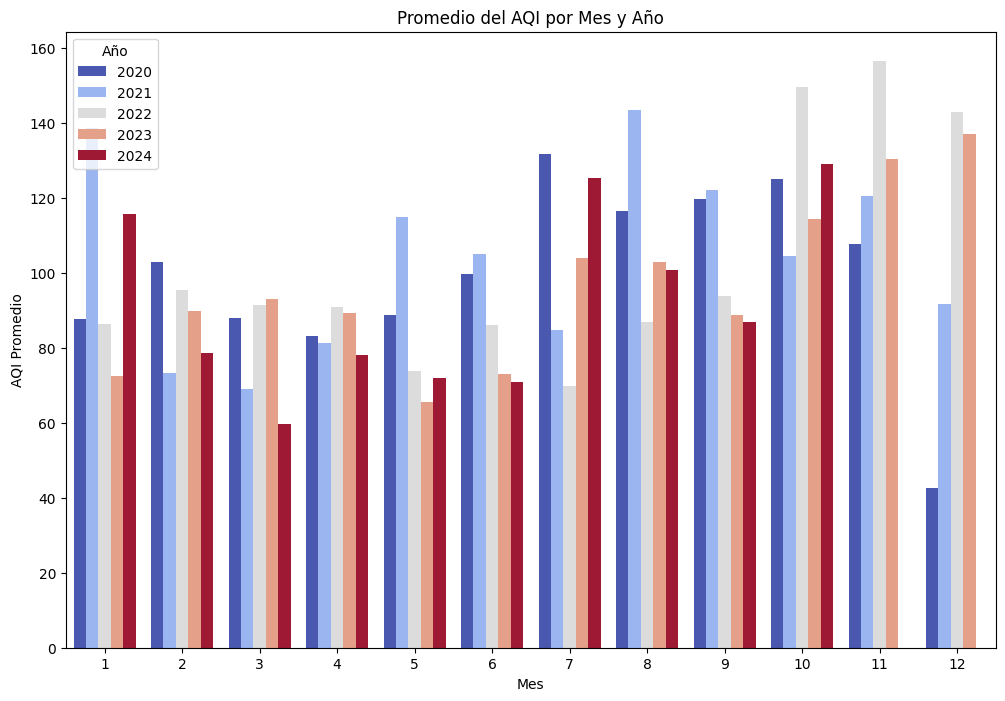

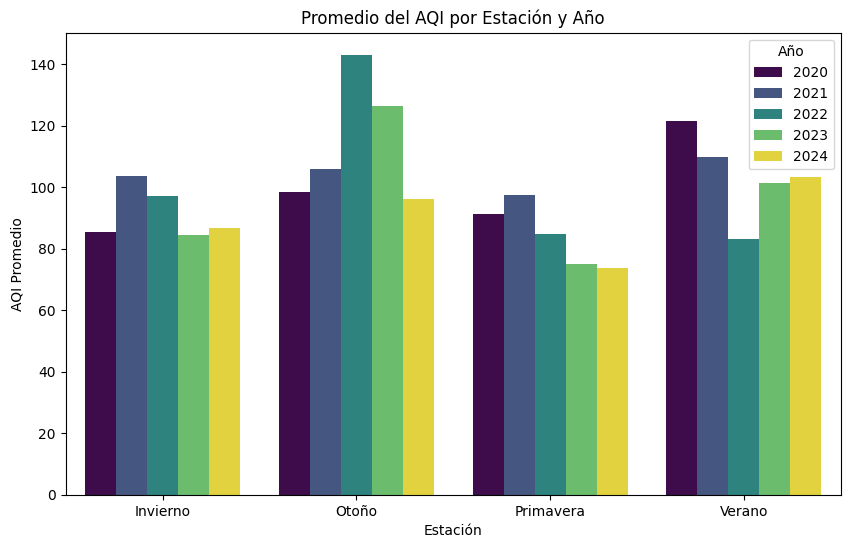

In [19]:
# 2. Extraer a√±o y mes
df['A√±o'] = df.index.year  # Extraemos el a√±o

# 3. Funci√≥n para asignar estaciones üå±‚òÄÔ∏èüçÇ‚ùÑÔ∏è
def asignar_estacion(fecha):
    mes = fecha.month
    dia = fecha.day
    if (mes == 3 and dia >= 21) or (mes in [4, 5]) or (mes == 6 and dia < 21):
        return 'Primavera'
    elif (mes == 6 and dia >= 21) or (mes in [7, 8]) or (mes == 9 and dia < 21):
        return 'Verano'
    elif (mes == 9 and dia >= 21) or (mes in [10, 11]) or (mes == 12 and dia < 21):
        return 'Oto√±o'
    else:
        return 'Invierno'

# 4. Aplicar la funci√≥n a las fechas
df['Estacion'] = df.index.map(asignar_estacion)

# 5. Calcular el promedio del AQI para cada mes de cada a√±o
promedio_aqi = df.groupby(['A√±o', 'Mes'])['AQI'].mean().reset_index()

# 6. Crear un gr√°fico comparativo üìä
plt.figure(figsize=(12, 8))
sns.barplot(x='Mes', y='AQI', hue='A√±o', data=promedio_aqi, palette='coolwarm')
plt.title('Promedio del AQI por Mes y A√±o')
plt.xlabel('Mes')
plt.ylabel('AQI Promedio')
plt.legend(title='A√±o')
plt.show()

# 7. Calcular promedios por estaci√≥n üçÉ
promedio_estacion = df.groupby(['A√±o', 'Estacion'])['AQI'].mean().reset_index()

# 8. Gr√°fico de promedios por estaci√≥n üìâ
plt.figure(figsize=(10, 6))
sns.barplot(x='Estacion', y='AQI', hue='A√±o', data=promedio_estacion, palette='viridis')
plt.title('Promedio del AQI por Estaci√≥n y A√±o')
plt.xlabel('Estaci√≥n')
plt.ylabel('AQI Promedio')
plt.legend(title='A√±o')
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  int64  
 1   DEWP      41757 non-null  int64  
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  int64  
 7   Ir        41757 non-null  int64  
 8   AQI       41757 non-null  int64  
 9   Mes       41757 non-null  int32  
 10  A√±o       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(3), int32(2), int64(5), object(2)
memory usage: 3.8+ MB


In [21]:
desc(df, columns=['AQI'])

count       mean        std  min   25%   50%    75%    max  %std/mean
AQI  41757.0  98.613215  92.050387  0.0  29.0  72.0  137.0  994.0      93.34

### ¬øPor qu√© MinMaxScaler para Redes Neuronales (RNN)?

**Redes neuronales y sensibilidad al rango:**

Las redes neuronales funcionan mejor cuando los datos est√°n en un rango peque√±o y uniforme, como [0, 1].
La presencia de valores muy grandes o muy peque√±os (outliers) puede causar que la red no converja correctamente o tarde mucho m√°s en entrenarse.
Funci√≥n de activaci√≥n:

Muchas funciones de activaci√≥n (como sigmoid o tanh) funcionan dentro de un rango espec√≠fico:
Sigmoid: Rango [0, 1]
Tanh: Rango [-1, 1]
Al usar MinMaxScaler, aseguras que los datos coincidan mejor con estos rangos, lo que mejora el aprendizaje y la estabilidad.
Datos no necesariamente normales:

Si los datos no siguen una distribuci√≥n gaussiana (lo cual es com√∫n en series temporales), MinMaxScaler mantiene la forma de la distribuci√≥n intacta y no introduce sesgo.
Aplicaciones en series temporales:

En series temporales, los valores absolutos importan m√°s que la media y la desviaci√≥n est√°ndar, por lo que MinMaxScaler es m√°s intuitivo.

## Conclusi√≥n:
Para Redes Neuronales Recurrentes (RNN), MinMaxScaler es preferido porque:

Escala los datos a un rango adecuado para las funciones de activaci√≥n.
Es robusto frente a la distribuci√≥n de los datos.
Mejora la eficiencia del entrenamiento y la convergencia del modelo.

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Paso 1: Conservar el √≠ndice original
indice_original = df.index

# Paso 2: Seleccionar solo las columnas num√©ricas para escalar (excluyendo 'Fecha' si est√° como columna)
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Si 'Fecha' es una columna adicional (y no est√° como √≠ndice), la excluimos expl√≠citamente
columnas_numericas = [col for col in columnas_numericas if col != 'Fecha']

# Crear el MinMaxScaler
scaler = MinMaxScaler()

# Aplicar el escalado solo a las columnas num√©ricas (exceptuando 'Fecha')
df_escalado = df.copy()
df_escalado[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# 5. Mostrar el resultado escalado
print("Datos escalados:")
print(df_escalado.head())

# Paso 3: Restaurar el √≠ndice original (si es que no lo hab√≠as perdido)
df_escalado.index = indice_original

# Verificar el √≠ndice
print(df_escalado.index)


Datos escalados:
                           No      DEWP      TEMP      PRES cbwd       Iws  \
Fecha                                                                        
2020-01-01 00:00:00  0.000000  0.352941  0.245902  0.527273   SE  0.002372   
2020-01-01 01:00:00  0.000024  0.367647  0.245902  0.527273   SE  0.003947   
2020-01-01 02:00:00  0.000048  0.426471  0.229508  0.545455   SE  0.005522   
2020-01-01 03:00:00  0.000072  0.485294  0.229508  0.563636   SE  0.008690   
2020-01-01 04:00:00  0.000096  0.485294  0.229508  0.563636   SE  0.010265   

                           Is   Ir       AQI  Mes   A√±o  Estacion  
Fecha                                                              
2020-01-01 00:00:00  0.000000  0.0  0.129779    1  2020  Invierno  
2020-01-01 01:00:00  0.000000  0.0  0.148893    1  2020  Invierno  
2020-01-01 02:00:00  0.000000  0.0  0.159960    1  2020  Invierno  
2020-01-01 03:00:00  0.037037  0.0  0.182093    1  2020  Invierno  
2020-01-01 04:00:00  0.0740

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  int64  
 1   DEWP      41757 non-null  int64  
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  int64  
 7   Ir        41757 non-null  int64  
 8   AQI       41757 non-null  int64  
 9   Mes       41757 non-null  int32  
 10  A√±o       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(3), int32(2), int64(5), object(2)
memory usage: 3.8+ MB


##3. Implementaci√≥n de RNN con LSTM:
- Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
- Aseg√∫rate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las √∫ltimas partes para probar la precisi√≥n de las predicciones.

### Paso 1: Preparar la serie temporal

Queremos predecir la columna 'AQI'. Para hacerlo, extraemos los valores de la columna 'AQI' del DataFrame escalado (df_escalado). Como el √≠ndice es la fecha, usaremos el √≠ndice como la serie temporal.

In [24]:
# Extraemos la serie temporal (en este caso, 'AQI')
serie_temporal_values = df_escalado['AQI'].values  # Usamos los valores de la columna AQI


### Paso 2: Crear las secuencias para LSTM
Ahora necesitamos crear las secuencias de datos. LSTM requiere que los datos de entrada est√©n en forma de secuencias temporales, y cada secuencia tendr√° un n√∫mero fijo de valores anteriores (lo que llamamos time_step).

Por ejemplo, si time_step=10, para predecir el valor en el time_step+1, el modelo usar√° los √∫ltimos 10 valores de la serie temporal como entrada.

La funci√≥n create_dataset toma los valores de 'AQI' y los convierte en secuencias de tiempo.

In [25]:
# Funci√≥n para crear las secuencias de datos (X, y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])  # Los valores de la serie temporal en el tiempo i hasta i+time_step
        y.append(data[i + time_step])    # El valor siguiente (lo que queremos predecir)
    return np.array(X), np.array(y)

# Usamos un time_step de 10
time_step = 10
X, y = create_dataset(serie_temporal_values, time_step)


### Paso 3: Reshape de los datos
LSTM espera los datos de entrada en un formato espec√≠fico: muestras, time_steps, caracter√≠sticas. Esto significa que necesitamos reorganizar X para tener esta forma.

In [26]:
X = X.reshape(X.shape[0], X.shape[1], 1)  # [muestras, time_steps, 1]

En este caso, como estamos usando solo una serie (la columna 'AQI'), tenemos solo una caracter√≠stica (es decir, 1 en la √∫ltima dimensi√≥n).

### Paso 4: Dividir en conjuntos de entrenamiento y prueba
El siguiente paso es dividir los datos en entrenamiento y prueba. En este caso, usaremos los primeros datos para entrenar y los √∫ltimos para probar, ya que estamos tratando con datos de series temporales, lo cual requiere preservar el orden temporal.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Paso 5: Crear y entrenar el modelo LSTM
Ahora que tenemos los datos listos, podemos construir y entrenar el modelo LSTM.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1044/1044 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_absolute_error: 0.0293 - val_mean_squared_error: 0.0019
Epoch 2/50
1044/1044 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0277 - mean_squared_error: 0.0018 - val_loss: 0.0019 - val_mean_absolute_error: 0.0215 - val_mean_squared_error: 0.0011
Epoch 3/50
1044/1044 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0250 - mean_squared_error: 0.0015 - val_loss: 0.0017 - val_mean_absolute_error: 0.0230 - val_mean_squared_error: 0.0011
Epoch 4/50
1044/1044 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0242 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_absolute_error: 0.0241 - val_mean_squ

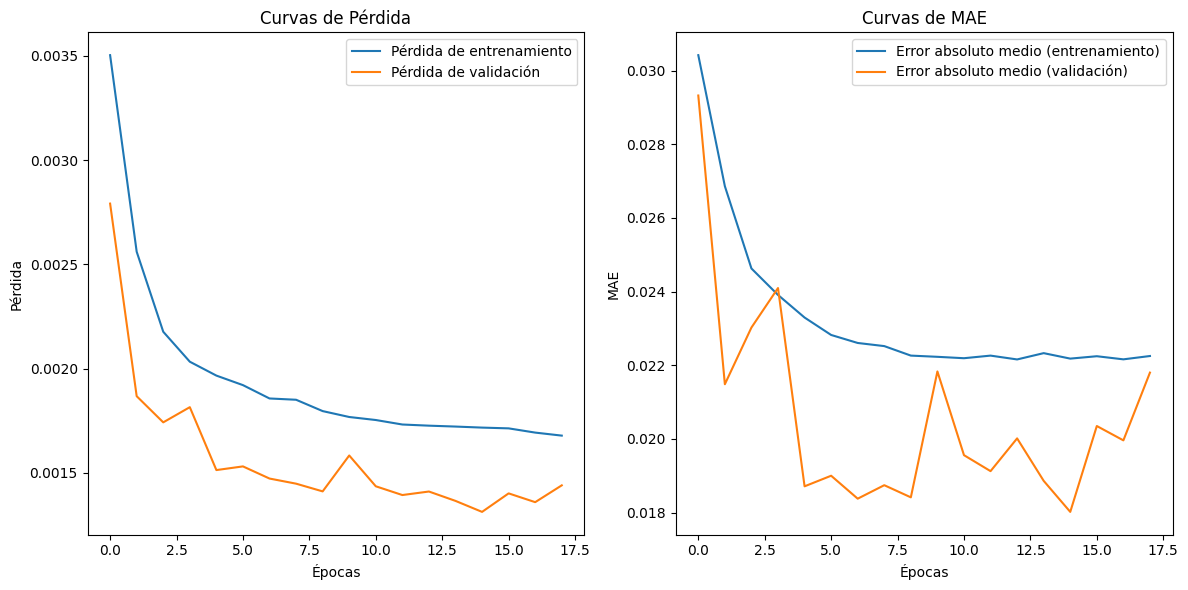

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Crear el modelo LSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(units=50,
                   return_sequences=False,
                   input_shape=(X_train.shape[1], 1),
                   kernel_regularizer=l2(0.001)))  # Regularizaci√≥n L2
modelLSTM.add(Dropout(0.2))  # Dropout del 20% para evitar sobreajuste
modelLSTM.add(Dense(units=1, kernel_regularizer=l2(0.001)))  # Regularizaci√≥n L2 en la capa densa

# Compilar el modelo con m√©tricas adicionales
modelLSTM.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error', 'mean_squared_error'])

# Early Stopping: Detiene el entrenamiento si no mejora en 3 √©pocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = modelLSTM.fit(X_train, y_train,
                        epochs=50,  # M√°s √©pocas, pero el Early Stopping lo detendr√° si no mejora
                        batch_size=32,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])  # A√±adir Early Stopping

# Graficar las curvas de p√©rdida y m√©tricas
import matplotlib.pyplot as plt

# Graficar la p√©rdida (loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='P√©rdida de entrenamiento')
plt.plot(history.history['val_loss'], label='P√©rdida de validaci√≥n')
plt.title('Curvas de P√©rdida')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()

# Graficar una m√©trica adicional (Mean Absolute Error en este caso)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Error absoluto medio (entrenamiento)')
plt.plot(history.history['val_mean_absolute_error'], label='Error absoluto medio (validaci√≥n)')
plt.title('Curvas de MAE')
plt.xlabel('√âpocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


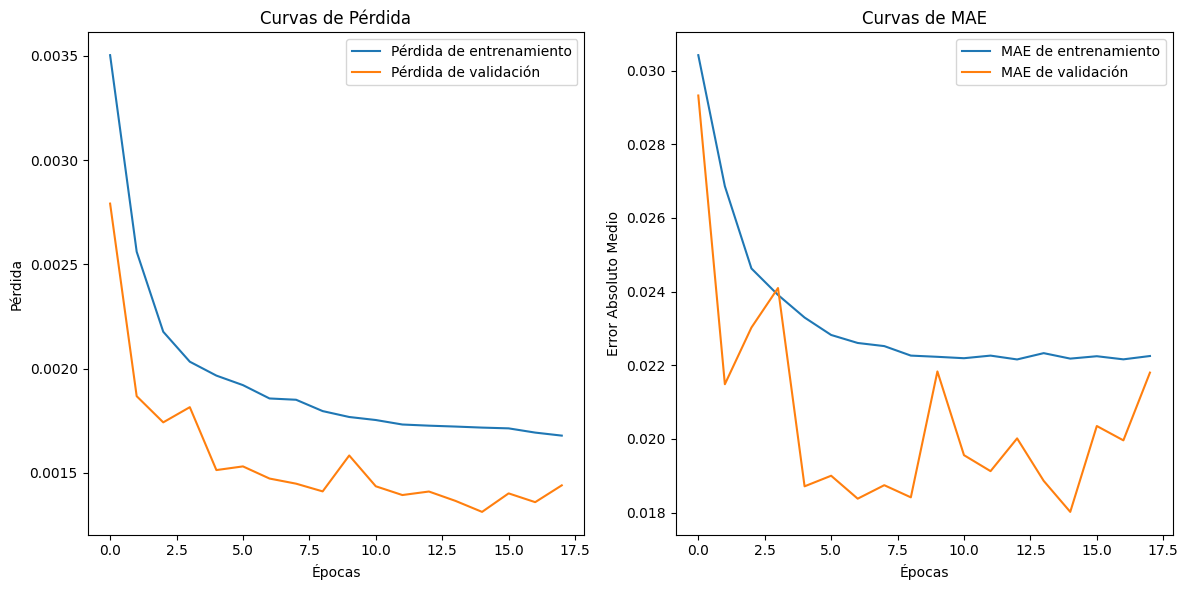

261/261 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step


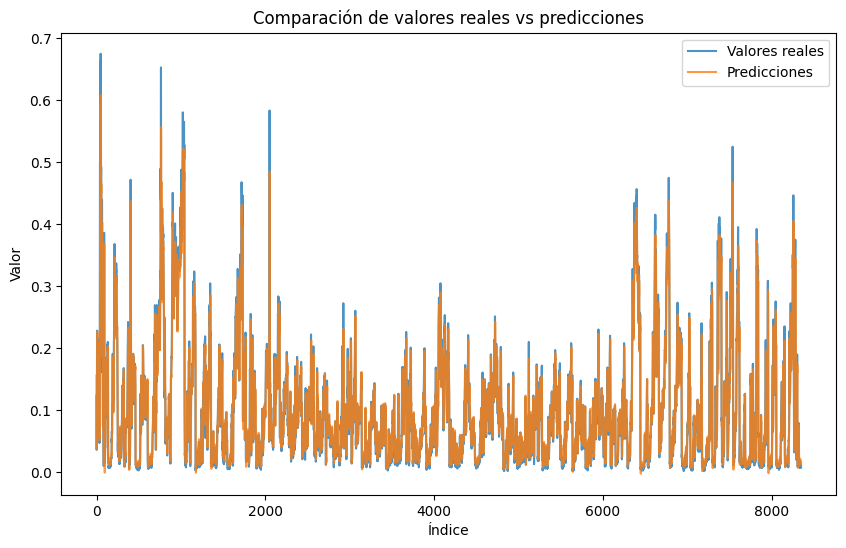

In [29]:
# Graficar las curvas de p√©rdida y m√©tricas
import matplotlib.pyplot as plt

# Curvas de P√©rdida y MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='P√©rdida de entrenamiento')
plt.plot(history.history['val_loss'], label='P√©rdida de validaci√≥n')
plt.title('Curvas de P√©rdida')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='MAE de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='MAE de validaci√≥n')
plt.title('Curvas de MAE')
plt.xlabel('√âpocas')
plt.ylabel('Error Absoluto Medio')
plt.legend()

plt.tight_layout()
plt.show()

# Gr√°fico de comparaci√≥n entre predicciones y valores reales
y_pred = modelLSTM.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales', alpha=0.8)
plt.plot(y_pred, label='Predicciones', alpha=0.8)
plt.title('Comparaci√≥n de valores reales vs predicciones')
plt.xlabel('√çndice')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Paso 6: Hacer predicciones
Finalmente, hacemos las predicciones en el conjunto de prueba:

In [30]:
# Hacer predicciones
predictions = modelLSTM.predict(X_test)


261/261 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step


### Paso 7: Graficar los resultados
Podemos graficar los resultados para ver c√≥mo se comporta la predicci√≥n frente a los valores reales:

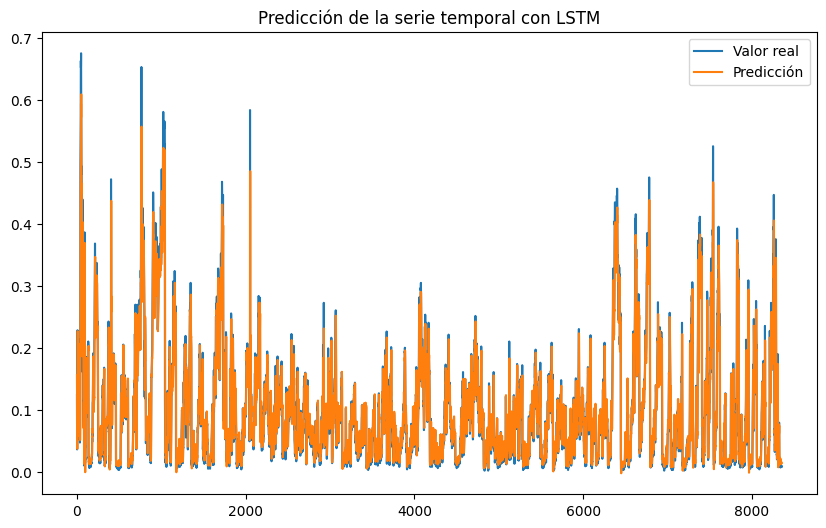

In [31]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Valor real')
plt.plot(predictions, label='Predicci√≥n')
plt.title('Predicci√≥n de la serie temporal con LSTM')
plt.legend()
plt.show()


Me gusta, aparentemente no tiene overfitting.

In [32]:
desc(df, columns=['AQI'])

count       mean        std  min   25%   50%    75%    max  %std/mean
AQI  41757.0  98.613215  92.050387  0.0  29.0  72.0  137.0  994.0      93.34

In [33]:
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

# Calcular la ra√≠z cuadrada del error cuadr√°tico medio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')


r2 = r2_score(y_test, predictions)
print(f'R¬≤: {r2}')
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'MAPE: {mape}%')

def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Para evitar divisi√≥n por cero
    return 100 * np.mean(diff)

smape_value = smape(y_test, predictions)
print(f'SMAPE: {smape_value}%')


MSE: 0.0009364597076427527
RMSE: 0.03060162916647989
MAE: 0.01801808062622118
R¬≤: 0.8959211799554341
MAPE: 256.1739733625951%
SMAPE: 45.71299845061173%


##4. Uso de Prophet:
  - Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja f√°cilmente tendencias y estacionalidades, por lo que es ideal para comparaci√≥n con redes recurrentes.
  - Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.


In [34]:
#pip install prophet


In [35]:
# Verificar si el √≠ndice es de tipo datetime
print(df_escalado.index)


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2024-10-05 11:00:00', '2024-10-05 12:00:00',
               '2024-10-05 13:00:00', '2024-10-05 14:00:00',
               '2024-10-05 15:00:00', '2024-10-05 16:00:00',
               '2024-10-05 17:00:00', '2024-10-05 18:00:00',
               '2024-10-05 19:00:00', '2024-10-05 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=41757, freq=None)


In [36]:
# Convertir el √≠ndice a una lista
indice_lista = list(df_escalado.index)
print(indice_lista[:10])  # Muestra los primeros 10 valores del √≠ndice como lista



[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-01 01:00:00'), Timestamp('2020-01-01 02:00:00'), Timestamp('2020-01-01 03:00:00'), Timestamp('2020-01-01 04:00:00'), Timestamp('2020-01-01 05:00:00'), Timestamp('2020-01-01 06:00:00'), Timestamp('2020-01-01 07:00:00'), Timestamp('2020-01-01 08:00:00'), Timestamp('2020-01-01 09:00:00')]


In [37]:
df_train

No  DEWP  TEMP    PRES cbwd     Iws  Is  Ir  AQI
0          1   -16  -4.0  1020.0   SE    1.79   0   0  129
1          2   -15  -4.0  1020.0   SE    2.68   0   0  148
2          3   -11  -5.0  1021.0   SE    3.57   0   0  159
3          4    -7  -5.0  1022.0   SE    5.36   1   0  181
4          5    -7  -5.0  1022.0   SE    6.25   2   0  138
...      ...   ...   ...     ...  ...     ...  ..  ..  ...
41752  41753   -23  -2.0  1034.0   NW  231.97   0   0    8
41753  41754   -22  -3.0  1034.0   NW  237.78   0   0   10
41754  41755   -22  -3.0  1034.0   NW  242.70   0   0   10
41755  41756   -22  -4.0  1034.0   NW  246.72   0   0    8
41756  41757   -21  -3.0  1034.0   NW  249.85   0   0   12

[41757 rows x 9 columns]

In [38]:
df_escalado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2020-01-01 00:00:00 to 2024-10-05 20:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        41757 non-null  float64
 1   DEWP      41757 non-null  float64
 2   TEMP      41757 non-null  float64
 3   PRES      41757 non-null  float64
 4   cbwd      41757 non-null  object 
 5   Iws       41757 non-null  float64
 6   Is        41757 non-null  float64
 7   Ir        41757 non-null  float64
 8   AQI       41757 non-null  float64
 9   Mes       41757 non-null  int32  
 10  A√±o       41757 non-null  int32  
 11  Estacion  41757 non-null  object 
dtypes: float64(8), int32(2), object(2)
memory usage: 3.8+ MB


In [39]:
df_escalado.head()

No      DEWP      TEMP      PRES cbwd       Iws  \
Fecha                                                                        
2020-01-01 00:00:00  0.000000  0.352941  0.245902  0.527273   SE  0.002372   
2020-01-01 01:00:00  0.000024  0.367647  0.245902  0.527273   SE  0.003947   
2020-01-01 02:00:00  0.000048  0.426471  0.229508  0.545455   SE  0.005522   
2020-01-01 03:00:00  0.000072  0.485294  0.229508  0.563636   SE  0.008690   
2020-01-01 04:00:00  0.000096  0.485294  0.229508  0.563636   SE  0.010265   

                           Is   Ir       AQI  Mes   A√±o  Estacion  
Fecha                                                              
2020-01-01 00:00:00  0.000000  0.0  0.129779    1  2020  Invierno  
2020-01-01 01:00:00  0.000000  0.0  0.148893    1  2020  Invierno  
2020-01-01 02:00:00  0.000000  0.0  0.159960    1  2020  Invierno  
2020-01-01 03:00:00  0.037037  0.0  0.182093    1  2020  Invierno  
2020-01-01 04:00:00  0.074074  0.0  0.138833    1  2020  Invierno

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcexgbou7/g02euan3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcexgbou7/x9k4hnk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24091', 'data', 'file=/tmp/tmpcexgbou7/g02euan3.json', 'init=/tmp/tmpcexgbou7/x9k4hnk5.json', 'output', 'file=/tmp/tmpcexgbou7/prophet_model7id_8ok0/prophet_model-20241227004849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


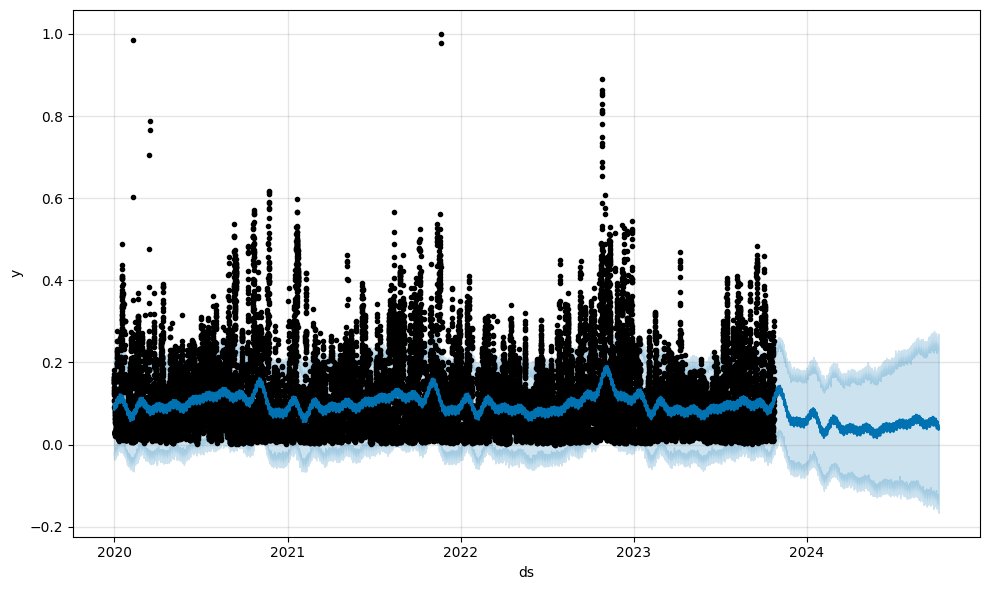

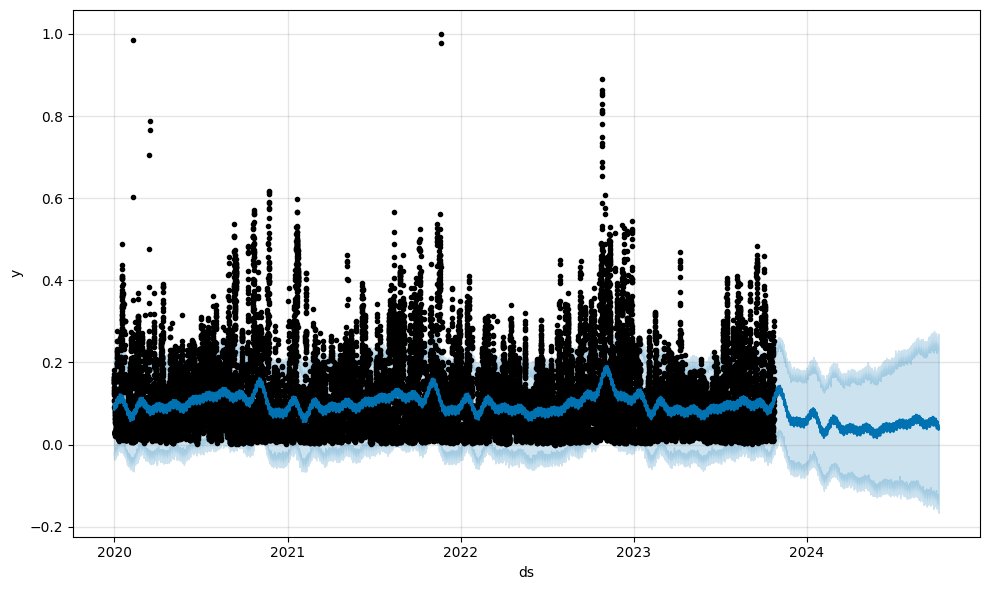

In [40]:
from prophet import Prophet
import pandas as pd

# Preparar los datos para Prophet
# Aseg√∫rate de que 'Fecha' est√© en formato datetime y sea el √≠ndice
df_prophet = df_escalado.reset_index()[['Fecha', 'AQI']]

# Renombrar las columnas para que Prophet las reconozca
df_prophet = df_prophet.rename(columns={'Fecha': 'ds', 'AQI': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Dividir en entrenamiento y prueba
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(df_train)

# Realizar las predicciones
future = model.make_future_dataframe(periods=len(df_test), freq='h')  # extendemos el DataFrame para predicciones
forecast = model.predict(future)

# Predicciones para el conjunto de prueba
predictions_prophet = forecast['yhat'][-len(df_test):].values

# Visualizar el modelo y las predicciones
model.plot(forecast)


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predicciones para el conjunto de prueba
predictions_prophet = forecast['yhat'][-len(df_test):].values
y_true = df_test['y'].values  # Los valores reales del conjunto de prueba

# Calcular MSE, RMSE, MAE, R2
mse = mean_squared_error(y_true, predictions_prophet)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, predictions_prophet)
r2 = r2_score(y_true, predictions_prophet)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - predictions_prophet) / y_true)) * 100

# Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(y_true - predictions_prophet) / (np.abs(y_true) + np.abs(predictions_prophet))) * 100

# Imprimir las m√©tricas
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAPE: {mape:.4f}%')
print(f'SMAPE: {smape:.4f}%')


MSE: 0.0110
RMSE: 0.1047
MAE: 0.0692
R2: -0.2175
MAPE: 131.2588%
SMAPE: 80.8889%


# 5. Comparaci√≥n de resultados:
  - Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza m√©tricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisi√≥n de ambos modelos.

| M√©trica  | Bajo | Alto |
|----------|------|------|
| **RMSE** | Cerca de 0 (mejor) | Depende de la escala de los datos, pero valores muy altos son malos. |
| **MAE**  | Cerca de 0 (mejor) | Entre 5 a 10 podr√≠a ser bueno en un rango de valores de 0 a 200. |
| **MAPE** | < 5% es excelente, < 10% es muy bueno | > 20% indica mala precisi√≥n, **valores extremadamente altos pueden indicar problemas de escala**. |
| **SMAPE** | < 10% es excelente, < 20% es muy bueno | > 50% indica un ajuste deficiente, **valores cerca de 50% son aceptables pero se pueden mejorar**. |
| **R¬≤**   | Cercano a 0 (malo) | Cercano a 1 (mejor), > 0.80 es generalmente bueno. |



## Comparaci√≥n de M√©tricas: LSTM vs Prophet

| **M√©trica**  | **LSTM**                            | **Prophet**                        |
|--------------|-------------------------------------|------------------------------------|
| **MSE**      | 0.000936                            | 0.0110                             |
| **RMSE**     | 0.0306                              | 0.1047                             |
| **MAE**      | 0.0180                              | 0.0692                             |
| **R¬≤**       | 0.8959                              | -0.2175                            |
| **MAPE**     | 256.17%                             | 131.26%                            |
| **SMAPE**    | 45.71%                              | 80.89%                             |

---

### An√°lisis Comparativo

1. **MSE (Error cuadr√°tico medio):**
   - **LSTM** tiene un valor de **0.000936**, que es muy bajo en comparaci√≥n con **Prophet** (**0.0110**). Esto indica que el modelo LSTM tiene un error m√°s peque√±o en t√©rminos de las diferencias al cuadrado entre los valores predichos y los reales.
   - **LSTM es m√°s preciso** en este aspecto, mostrando una mejor capacidad para minimizar los errores grandes.

2. **RMSE (Ra√≠z del error cuadr√°tico medio):**
   - **LSTM** tiene un **RMSE** de **0.0306**, mientras que **Prophet** tiene un **RMSE** mucho mayor de **0.1047**.
   - **LSTM tiene un RMSE mucho m√°s bajo**, lo que indica que sus predicciones son, en promedio, mucho m√°s cercanas a los valores reales que las de Prophet.

3. **MAE (Error absoluto medio):**
   - **LSTM** tiene un **MAE** de **0.0180**, mientras que **Prophet** tiene un **MAE** de **0.0692**.
   - Al igual que en las m√©tricas anteriores, **LSTM tiene un MAE mucho m√°s bajo**, lo que indica que las predicciones de LSTM son m√°s exactas y presentan menos error absoluto en comparaci√≥n con Prophet.

4. **R¬≤ (Coeficiente de determinaci√≥n):**
   - **LSTM** tiene un **R¬≤** de **0.8959**, lo que indica que el modelo explica aproximadamente el **90%** de la variabilidad de los datos, lo que es una excelente indicaci√≥n de que el modelo tiene un buen rendimiento.
   - **Prophet**, en cambio, tiene un **R¬≤** de **-0.2175**, lo que indica que el modelo es **muy pobre** en comparaci√≥n con la media. En este caso, **Prophet no est√° capturando bien las relaciones en los datos**.

5. **MAPE (Error absoluto medio porcentual):**
   - **LSTM** tiene un **MAPE** extremadamente alto de **256.17%**, lo que es preocupante ya que generalmente los valores de MAPE deben estar por debajo del 100%. Este valor puede sugerir que el modelo LSTM tiene algunos casos de gran error en comparaci√≥n con los valores reales, aunque su error en t√©rminos absolutos es bajo.
   - **Prophet** tiene un **MAPE** de **131.26%**, lo que es significativamente m√°s bajo que el de LSTM, pero a√∫n as√≠ est√° bastante por encima de lo deseado. Esto muestra que **Prophet tiene un error m√°s relativo** en t√©rminos porcentuales que LSTM.

6. **SMAPE (Error porcentual absoluto sim√©trico):**
   - **LSTM** tiene un **SMAPE** de **45.71%**, lo que es un buen resultado, ya que el SMAPE se considera una m√©trica robusta para series temporales. Generalmente, valores por debajo del 50% son bastante buenos.
   - **Prophet**, por otro lado, tiene un **SMAPE** de **80.89%**, lo que indica que **Prophet tiene un error porcentual mucho mayor** que LSTM.

---

### Conclusiones

- **LSTM** parece ser el modelo **superior** en t√©rminos de precisi√≥n y capacidad de ajuste a los datos, ya que tiene menores errores absolutos y cuadr√°ticos, as√≠ como un **R¬≤ significativamente alto**.
- **Prophet**, aunque m√°s interpretativo y f√°cil de usar para series temporales, tiene un desempe√±o m√°s pobre seg√∫n las m√©tricas de **MSE**, **RMSE**, **MAE**, y **R¬≤**.
- El **MAPE** y **SMAPE** de LSTM son m√°s altos, pero en general, LSTM es un modelo m√°s adecuado para capturar las relaciones subyacentes en los datos, mientras que **Prophet** tiene dificultades para ajustarse bien a los datos.

**Recomendaci√≥n:** Dado que **LSTM** tiene un mejor desempe√±o global en comparaci√≥n con **Prophet** en este caso, podr√≠a ser preferible seguir optimizando el modelo LSTM y explorar t√©cnicas adicionales como ajuste de hiperpar√°metros o uso de m√°s datos.



**En terminos m√°s sencillos**
- **LSTM** es como un estudiante que hace su tarea muy bien. Si miramos lo que predice, casi siempre est√° cerca de la respuesta correcta. Por ejemplo, el error de **LSTM** es muy peque√±o, lo que significa que sus respuestas est√°n muy cerca de las respuestas reales.

- **Prophet** es como un estudiante que tiene m√°s dificultades. Su tarea tiene errores m√°s grandes. Por ejemplo, sus respuestas est√°n m√°s lejos de la correcta. Adem√°s, cuando tratamos de ver cu√°nto puede explicar sobre los datos, **Prophet** no lo hace muy bien, mientras que **LSTM** lo hace casi perfecto.

- En resumen, **LSTM** es un modelo mucho m√°s preciso y hace predicciones mucho mejores que **Prophet**. Aunque **Prophet** no es tan malo, **LSTM** es el que mejor resuelve el problema.

---

### ¬øQu√© significa todo esto?

- **LSTM** tiene **menos errores** y es **m√°s preciso**, por eso es el modelo que funciona mejor.
- **Prophet** tiene **m√°s errores** y no puede explicar bien los datos, por lo que **LSTM** ser√≠a la mejor opci√≥n si quieres que las predicciones sean lo m√°s exactas posible.


Entonces en la pr√°ctica:

- **LSM tiene mejores adivinanzas** en n√∫meros exactos.
- **Prophet es mejor para ver las ideas generales** sin exagerar tanto.


#- Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cu√°l se ajusta mejor a los datos.

Paso 1: Preparar los datos
Primero, necesitamos asegurarnos de tener las predicciones de ambos modelos en un formato adecuado y alineadas con la serie temporal original.

In [42]:
# Crear un DataFrame para las predicciones de LSTM
predictions_lstm = pd.DataFrame(predictions, columns=['yhat_lstm'])
predictions_lstm['ds'] = df_prophet['ds'].iloc[train_size:].reset_index(drop=True)  # Fechas para el conjunto de prueba



In [43]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      41757 non-null  datetime64[ns]
 1   y       41757 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 652.6 KB


In [44]:
# Extraemos las predicciones de Prophet
forecast = model.predict(future)

# Asegur√©monos de que las predicciones est√©n en el formato correcto
df_prophet['yhat'] = forecast['yhat']


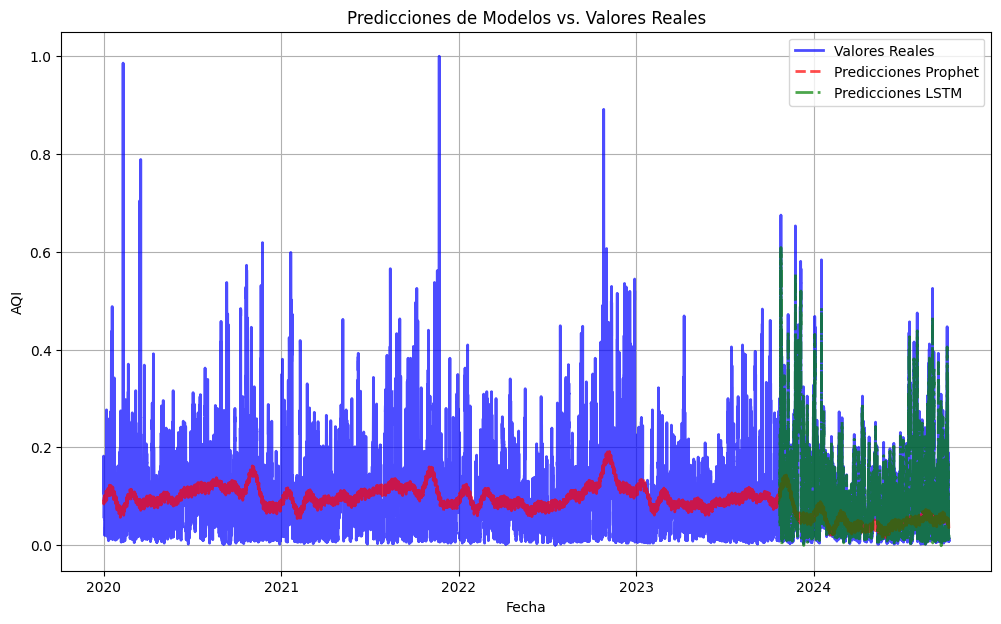

In [45]:
plt.figure(figsize=(12, 7))

# Graficar la serie temporal original
plt.plot(df_prophet['ds'], df_prophet['y'], label='Valores Reales', color='blue', alpha=0.7, linewidth=2)

# Graficar las predicciones de Prophet
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Predicciones Prophet', color='red', linestyle='--', alpha=0.7, linewidth=2)

# Graficar las predicciones de LSTM
plt.plot(predictions_lstm['ds'], predictions_lstm['yhat_lstm'], label='Predicciones LSTM', color='green', linestyle='-.', alpha=0.7, linewidth=2)

# T√≠tulos y leyenda
plt.title('Predicciones de Modelos vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.legend(loc='best')
plt.grid(True)

plt.show()


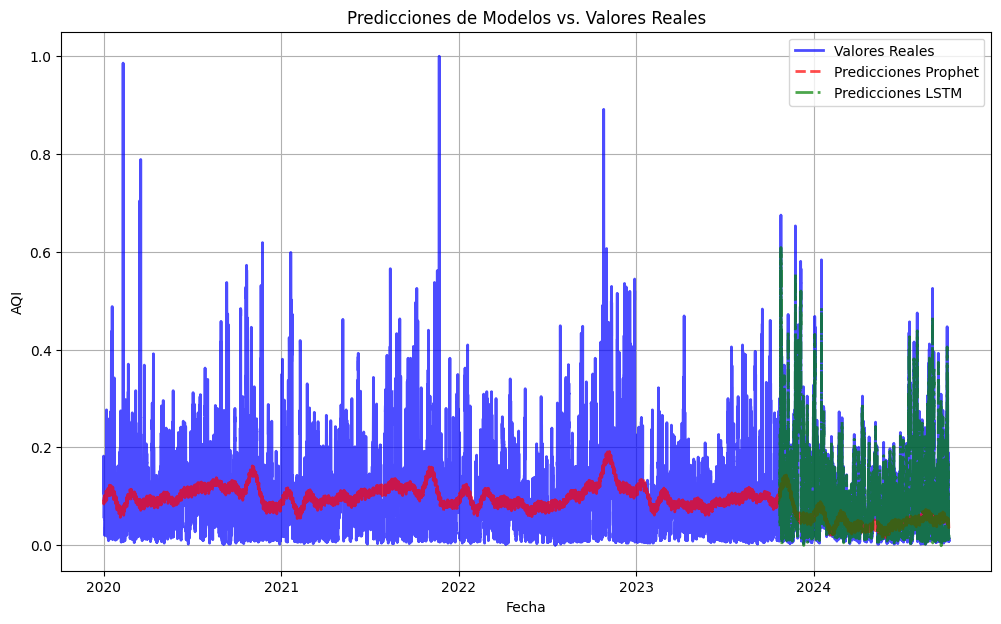

In [46]:
plt.figure(figsize=(12, 7))

# Graficar la serie temporal original
plt.plot(df_prophet['ds'], df_prophet['y'], label='Valores Reales', color='blue', alpha=0.7, linewidth=2)

# Graficar las predicciones de Prophet
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Predicciones Prophet', color='red', linestyle='--', alpha=0.7, linewidth=2)

# Graficar las predicciones de LSTM
plt.plot(predictions_lstm['ds'], predictions_lstm['yhat_lstm'], label='Predicciones LSTM', color='green', linestyle='-.', alpha=0.7, linewidth=2)

# T√≠tulos y leyenda
plt.title('Predicciones de Modelos vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('AQI')
plt.legend(loc='best')
plt.grid(True)

plt.show()


# 6. An√°lisis y discusi√≥n:
  - Discute cu√°l de los modelos ofrece mejores resultados en este caso particular. ¬øPor qu√© crees que Prophet o la red LSTM tuvieron un mejor rendimiento?
  - Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicci√≥n de series temporales.

### 6. An√°lisis y Discusi√≥n

#### ¬øCu√°l modelo funciona mejor?

- **LSTM** tiene mejores m√©tricas en comparaci√≥n con **Prophet**, lo que sugiere que es m√°s preciso en este caso.

#### Comparaci√≥n de m√©tricas:

| **M√©trica**    | **LSTM**                           | **Prophet**                     | **Ponderaci√≥n LSTM**  | **Ponderaci√≥n Prophet** |
|----------------|------------------------------------|---------------------------------|-----------------------|-------------------------|
| **MSE**        | 0.00093 (Error bajo +1)            | 0.0110 (Error alto +0)         | +1                    | +0                      |
| **RMSE**       | 0.0306 (Bajo +1)                   | 0.1047 (Alto +0)               | +1                    | +0                      |
| **MAE**        | 0.0180 (Bajo +1)                   | 0.0692 (Alto +0)               | +1                    | +0                      |
| **R¬≤**         | 0.896 (Buen ajuste +1)             | -0.2175 (Poco ajuste +0)       | +1                    | +0                      |
| **MAPE**       | 256.17% (Muy alto +0)             | 131.26% (Alto +1)              | +0                    | +1                      |
| **SMAPE**      | 45.71% (Mejor +1)                  | 80.89% (Peor +0)               | +1                    | +0                      |

#### ¬øPor qu√© LSTM tiene mejor rendimiento?

1. **LSTM** captura patrones m√°s complejos en los datos, lo que le permite hacer predicciones m√°s precisas.
2. **Prophet**, aunque f√°cil de usar, no maneja bien los patrones complejos y por eso tiene m√°s errores.

#### Ventajas y desventajas:

- **LSTM:**
  - **Ventajas:** Capta patrones complejos, preciso, y funciona mejor con grandes vol√∫menes de datos.
  - **Desventajas:** M√°s lento, necesita m√°s datos y recursos computacionales.

- **Prophet:**
  - **Ventajas:** R√°pido y f√°cil de usar, adecuado para datos con patrones simples.
  - **Desventajas:** No captura patrones complejos, por lo tanto, menos preciso.

#### Conclusi√≥n:

- **LSTM** es generalmente mejor para datos complejos y m√°s precisos, mientras que **Prophet** es adecuado para patrones m√°s simples, pero menos efectivo en comparaci√≥n con **LSTM**.
